# Black Scholes Model

The Black Scholes model was published in 1973 for non-dividend paying stocks and since then the model has created a revolution in quantitative finance and opened up derivatives pricing paradigm. Black Scholes model is based on number of assumptions about how financial markets operate and those are:

- Arbitrage Free Markets
- Frictionless and Continuous Markets
- Risk Free Rates
- Log-normally Distributed Price Movements
- Constant Volatility

These assumptions maynot hold true in reality, but are not particularly limiting. The generalized Black Scholes framework have been extended to price derivaties of other asset classes such as Black 76 (Commodity Futures) and Garman-Kohlhagen (FX Futures) that are currently used in derivative pricing and risk management.

## Black Scholes Formula

The Black–Scholes equation describes the price of the option over time as,

$$  \frac{\partial V}{\partial t} +\frac{1}{2}\sigma^2 S^2  \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - rV=0$$

Solving the above equation, we know that the value of a call option for a non-dividend paying stock is:

$$ C = S\ N(d_1) + K\ e^{-rt}N(d_2) $$

, and the corresponding put option price is:

$$ P = K\ e^{-rt}\ N(d_2) + S\ N(d_1) $$

, where

$$d_1 = \frac{1}{\sigma \sqrt{t}}\bigg[ ln\big(\frac{S}{K}\big) + \big(r+\frac{\sigma^2}{2}\big)t \bigg]$$

$$d_2 = d_1 - \sigma \sqrt{t}$$

$$N(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-\frac{1}{2} x^2 } dx$$

- $S$ is the spot price of the underlying asset
- $K$ is the strike price
- $r$ is the annualized continuous compounded risk free rate
- $\sigma$ is the volatility of returns of the underlying asset
- $t$ is time to maturity (expressed in years)
- $N(x)$ is the standard normal cumulative distribution

## Greeks

| Description | Notation                             | Greeks for Call Option                                 | **Greeks for Put Option**                              |
| ----------- | ------------------------------------ | ------------------------------------------------------ | ------------------------------------------------------ |
| **Delta**   | $\frac{\partial V}{\partial S}$      | $N(d_1)$                                               | $-N(-d_1)$                                             |
| **Gamma**   | $\frac{\partial^2 V}{\partial S^2}$  | $\frac{N'(d_1)}{S\sigma\sqrt{t}}$                      |                                                        |
| **Vega**    | $\frac{\partial V}{\partial \sigma}$ | $SN'(d_1)\sqrt{t}$                                     |                                                        |
| **Theta**   | $\frac{\partial V}{\partial t}$      | $\frac{SN'(d_1)\sigma}{2\sqrt{t}}$ $- rKe^{-rt}N(d_2)$ | $\frac{SN'(d_1)\sigma}{2\sqrt{t}}$$ + rKe^{-rt}N(d_2)$ |
| **Rho**     | $\frac{\partial V}{\partial r}$      | $Kte^{-rt}N(d_2)$                                      | $-Kte^{-rt}N(-d_2)$                                    |

## Options Object

Python is an object oriented programming language. Almost everything in Python is an object, with its properties and methods. There are two common programming paradigm in Python.

> - Procedural Programming 
> - Object-oriented Programming (OOP)

The key difference between them is that in OOP, objects are at the center, not only representing the data, as in the procedural programming, but in the overall structure of the program as well.

### Class

We use Classes to create user-defined data structures. Classes define functions called methods, which identify the characteristics and actions that an object created from the class can perform with its data. A Class is like an object constructor, or a "blueprint" for creating objects. To create a class, use the keyword **class**.

#### `__init__`

The properties of the class objects are defined in a method called 
`_init`

> - `__init__()` sets the initial state of the object by assigning the values of the object’s properties.
> - `__init__()` initializes each new instance of the class
> - `Attributes` created in `__init__()` are called instance attributes, while class attributes are attributes that have the same value for all class instances.

#### `self`

The self is a parameter used to represent the instance of the class. With self, you can access the attributes and methods of the class in python. It binds the attributes with the given arguments. When a new class instance is created, the instance is automatically passed to the self parameter in `__init__()` so that new attributes can be defined on the object.

> `__init__()` can any number of parameters, but the first parameter will always be a variable called self.

We will now construct a Black Scholes Options class

In [1]:
# Importing libraries
import pandas as pd
from numpy import *
import yfinance as yf
from scipy.stats import norm

# Plotting
import matplotlib.pyplot as plt
from tabulate import tabulate

# Set max row to 300
pd.set_option('display.max_rows', 300)

In [3]:
class BS:
    
    """
    This is a class for Options contract for pricing European options on stocks without dividends.
    
    Attributes: 
        spot          : int or float
        strike        : int or float 
        rate          : float
        dte           : int or float [days to expiration in number of years]
        volatility    : float
    """    
    
    def __init__(self, spot, strike, rate, dte, volatility):
        # Spot Price
        self.spot = spot
        # Option Strike
        self.strike = strike
        # Interest Rate
        self.rate = rate
        # Days To Expiration
        self.dte = dte
        # Volaitlity
        self.volatility = volatility
        # Utility 
        self._a_ = self.volatility * self.dte**0.5    # \sigma \sqrt{T}
        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')
        else:
            self._d1_ = (log(self.spot / self.strike) + \
                     (self.rate + (self.volatility**2) / 2) * self.dte) / self._a_  # d1 is the d_1 in B-S Fomula
        self._d2_ = self._d1_ - self._a_
        self._b_ = e** -(self.rate * self.dte)  # e^{-rt}
        

        # self.__dict__ is a built in method in the class.
        # append elements into the self.__dict__, containing all the varialbes in the __init__()
        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta', 'callTheta', 'putTheta', \
                  'callRho', 'putRho', 'vega', 'gamma']:
            self.__dict__[i] = None
        
        # calculate attribute through those methods inside the class.
        [self.callPrice, self.putPrice] = self._price()
        [self.callDelta, self.putDelta] = self._delta()
        [self.callTheta, self.putTheta] = self._theta()
        [self.callRho, self.putRho] = self._rho()
        self.vega = self._vega()
        self.gamma = self._gamma()
        
    
    # Option Price
    def _price(self):
        '''Returns the option price: [Call price, Put price]'''

        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)  # max(S-K,0)
            put = maximum(0.0, self.strike - self.spot)  # max(K-S,0)
        else:  # , Otherwise return the value calculated by the Black-Schole Fomula
            call = self.spot * norm.cdf(self._d1_) - self.strike * e**(-self.rate * \
                                                                       self.dte) * norm.cdf(self._d2_)
            put = self.strike * e**(-self.rate * self.dte) * norm.cdf(-self._d2_) - \
                                                                        self.spot * norm.cdf(-self._d1_)
        return [call, put]

    # Option Delta
    def _delta(self):
        '''Returns the option delta: [Call delta, Put delta]'''

        if self.volatility == 0 or self.dte == 0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = -norm.cdf(-self._d1_)
        return [call, put]

    # Option Gamma
    def _gamma(self):
        '''Returns the option gamma'''
        return norm.pdf(self._d1_) / (self.spot * self._a_)

    # Option Vega
    def _vega(self):
        '''Returns the option vega'''
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.dte**0.5 / 100

    # Option Theta
    def _theta(self):
        '''Returns the option theta: [Call theta, Put theta]'''
        call = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) - self.rate * self.strike * self._b_ * norm.cdf(self._d2_)
        put = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) + self.rate * self.strike * self._b_ * norm.cdf(-self._d2_)
        return [call / 365, put / 365]

    # Option Rho
    def _rho(self):
        '''Returns the option rho: [Call rho, Put rho]'''
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100
        return [call, put]

In [4]:
# Initialize option
option = BS(100,100,0.0,1,0.2)

header = ['Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.callPrice, option.callDelta, option.gamma, option.callTheta, option.vega, option.callRho]]

print(tabulate(table,header))

  Option Price     Delta      Gamma       Theta      Vega       Rho
--------------  --------  ---------  ----------  --------  --------
       7.96557  0.539828  0.0198476  -0.0108754  0.396953  0.460172


In [6]:
option.__dict__

{'spot': 100,
 'strike': 100,
 'rate': 0.0,
 'dte': 1,
 'volatility': 0.2,
 '_a_': 0.2,
 '_d1_': 0.10000000000000002,
 '_d2_': -0.09999999999999999,
 '_b_': 1.0,
 'callPrice': 7.965567455405804,
 'putPrice': 7.965567455405804,
 'callDelta': 0.539827837277029,
 'putDelta': -0.460172162722971,
 'callTheta': -0.010875412259644158,
 'putTheta': -0.010875412259644158,
 'callRho': 0.46017216272297096,
 'putRho': -0.539827837277029,
 'vega': 0.39695254747701175,
 'gamma': 0.01984762737385059}

## SPY Option

Let's now retrieve SPY option price from Yahoo Finance using yfinance library and manipulate the dataframe using the above Black Scholes option pricing model that we created.

https://finance.yahoo.com/quote/SPY/options?date=1680220800&p=SPY

In [32]:
# Get SPY option chain
spy = yf.Ticker('SPY')
options = spy.option_chain('2025-12-19')

In [55]:
from datetime import datetime
dte = (datetime(2025, 12, 19) - datetime.today()).days/365
print(dte)

2.712328767123288


In [54]:
# Dec 2025 400 SPY call option price
spot = 400; strike = 400; rate = 0.0; dte = dte; vol = 0.1805

spy_opt = BS(spot,strike,rate,dte,vol)
print(f'Option Price of SPY251219C00400000 with BS Model is {spy_opt.callPrice:0.4f}')

Option Price of SPY251219C00400000 with BS Model is 47.2630


In [56]:
# Verify the options output
options.calls.query(" contractSymbol=='SPY251219C00400000' ")

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
43,SPY251219C00400000,2023-03-31 19:53:37+00:00,400.0,70.26,0.0,0.0,0.0,0.0,10.0,0,0.00001,True,REGULAR,USD


In [90]:
# Filter calls for strike at or above 400
df = options.calls[options.calls['strike']>=400]
df.reset_index(drop=True, inplace=True)

# Dataframe manipulation with selected fields
df = pd.DataFrame({'Strike': df['strike'], 
                   'Price': df['lastPrice'], 
                   'ImpVol': df['impliedVolatility']})

# Derive greeks and assign to dataframe as columns
df['Delta'] = df['Gamma'] = df['Vega'] = df['Theta'] = 0.

# Calculate Greeks by BS Fomula row by row, by inputting the SPY's market data.
for i in range(len(df)):
    temp_obj = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i])
    df['Delta'].iloc[i] = temp_obj.callDelta
    df['Gamma'].iloc[i] = temp_obj.gamma
    df['Vega'].iloc[i] = temp_obj.vega
    df['Theta'].iloc[i] = temp_obj.callTheta

# Check output
df.head(5)

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,400.0,70.26,0.000010,5.000033e-01,6.055903e+01,2.628096e+00,-1.327321e-06
1,405.0,68.53,0.000010,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00
2,410.0,66.22,0.000254,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00
3,415.0,64.50,0.001963,2.481025e-30,2.200801e-29,1.874937e-28,-1.858939e-32
4,420.0,55.90,0.003916,1.991729e-14,5.936521e-14,1.008929e-12,-1.995544e-16


## Visualise Those Greeks

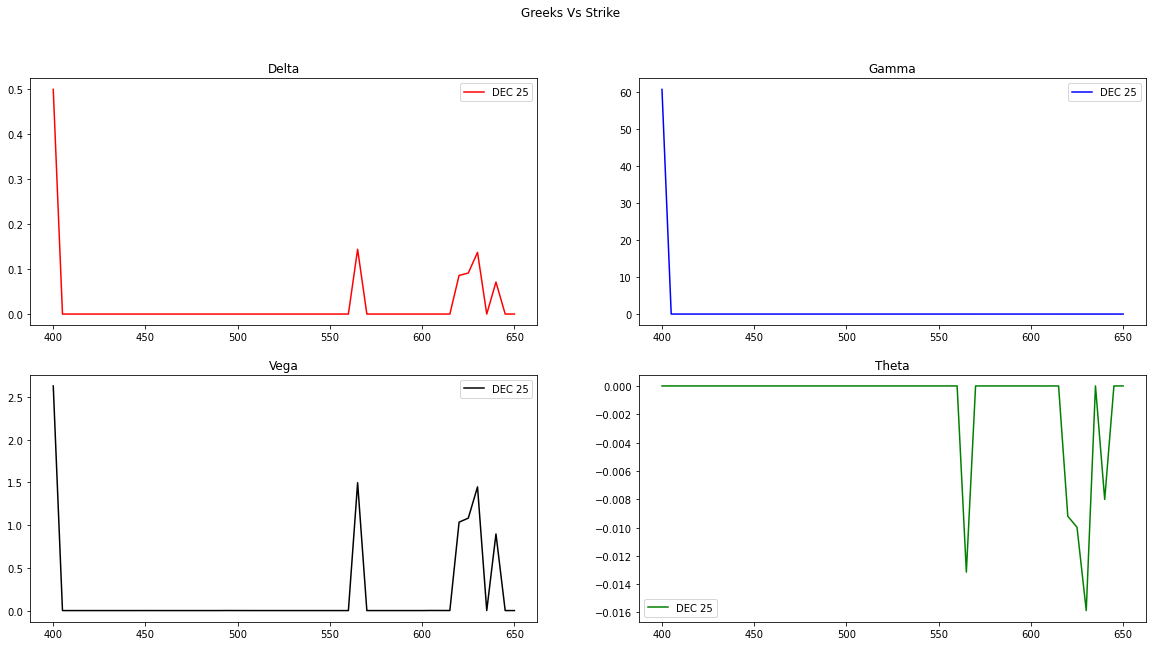

In [91]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].plot(df['Strike'], df['Delta'], color='r', label='DEC 25')
ax[0,1].plot(df['Strike'], df['Gamma'], color='b', label='DEC 25')
ax[1,0].plot(df['Strike'], df['Vega'], color='k', label='DEC 25')
ax[1,1].plot(df['Strike'], df['Theta'], color='g', label='DEC 25')
    
# Set axis title
ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

# Set title
fig.suptitle('Greeks Vs Strike')

plt.show()